In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy
import scipy.stats as st
import scipy.special
import pandas
import csv
import math
import multiprocessing as mp
import datetime
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive

## **Google Drive**

In [2]:
# connect to google drive to save the csv file
drive.mount('drive')
os.chdir("drive/My Drive/Yen-Ting Lin/Code")

Mounted at drive


## **Initial Parameters**

In [3]:
# define class to inital RA parameter
class init_RAparameter():
  # initail parameter for statistics value
  def __init__(self, sample, subcarrier_4sra):
    self.sample = sample # number of simulation time
    self.nUE = 0 # num_UE[0] # number of UE
    self.subcarrier = subcarrier_4sra # number of preamble
    # self.success_time = 0 # average access time
    self.MS = 0
    self.P_s = 0 # successful probability
    # self.uti # utilization
    self.iteMiSn = [[0]*(retrans + 1) for _ in range(0, maxslot())]
    self.iteMiFn = [[0]*(retrans + 1) for _ in range(0, maxslot())]
    self.totalMis = [[0]*(maxslot() + 1) for _ in range(0, sample)]
    self.Da = 0 # access delay
    self.Da_MiSn = 0
  # initail parameter for each iteration
  def define_RAparameter(self):
    self.dict_retr = 0
    # initial dict_prea = {0:0, 1:0, ..., nUE:0}, UE index : preamble
    self.dict_prea = gen_UE_prea(self.nUE)
    # initial slot_lit = [[], [], [], ..., []], ue number in each slot
    self.slot_list = [[] for j in range(0, maxslot() + 1)]
    # initial dict_backoffcnt = {0:0, 1:0, ..., nUE:0}, UE index : backoff counter
    self.dict_backoffcnt = gen_UE_backoffcnt(self.nUE)
    # initial UE_list[UE_id][x]
    # x=0 arrive time,     x=1 1st attempt time, x=2 2nd attemp time
    # x=3 3nd attemp time, x=4 4nd attempt time, x=5 RA status
    self.UE_list = [[-1]*(retrans + 3) for _ in range(0, self.nUE)]
    # initail arrive_num from slot0 to Imax
    self.arrive_num = [0 for j in range(0, maxslot())]
    # inital statistic value for each iteration
    self.MiSn = [[0]*(retrans + 1) for _ in range(0, maxslot())]
    self.MiFn = [[0]*(retrans + 1) for _ in range(0, maxslot())]
    self.T = [0 for j in range(0, maxslot())]
  def arrival_process(self, slot):
    # one-shot
    if slot == 0 :
      # initial dict_retr = {0:0, 1:0, ..., nUE:0}, UE index : retransmission counter
      self.dict_retr = gen_UE_id(self.nUE)
      self.arrive_num[slot] = len(self.dict_retr)
      for i in range (0, self.nUE):
        self.dict_backoffcnt[i] = 1
    # here can process other arrival process, ex: Possion
    else:
      self.arrive_num[slot] = len(self.dict_retr)
  def departure_process(self, slot, countdown):
    for ue in list(self.dict_retr):
      self.dict_backoffcnt[ue] -= countdown
      # when backoff conunter equal to 0 means it's time to contend the RACH resource
      if self.dict_backoffcnt[ue] <= 0:
        # genearate preamble for each of ue, EX: dict_prea = {0:23, 1:34, ..., nUE:16}
        self.dict_prea[ue] = doRA(self.subcarrier)
        # append ue in slot_list to know which ue in current slot, EX: slot_list = [[0,1,2,...,nUE], [...], ..., [...]]
        self.slot_list[slot].append(ue)
        # record infomation in UE_list
        self.UE_list[ue][self.dict_retr[ue] + 1] = slot
    # check the preamble to get the success ue and remove the success ue from dict_retr
    self.check_preamble(slot, self.subcarrier)
    # add retranmsission counter for failure ue in dict_retr
    doretrans(self.dict_retr, self.slot_list[slot], self.UE_list)
    # give the random backoff counter for the ue in dict_retr
    backoff(self.dict_retr, self.dict_backoffcnt, self.slot_list, slot)
  def check_preamble(self, slot, subcarrier):
    # check preamble from preamble 1 to subcarrier
    for preamble in range(1, int(subcarrier) + 1):
      # get which ue choose current preamble, EX: collided_ue = [1, 5, 23...]
      collided_ue = preak(self.dict_prea, self.slot_list[slot], preamble)
      # make sure the collided_ue is larger than 0 that means at least one ue choose this premable and mark this ue is success
      if len(collided_ue) != 0:
        find_succuss_RA(self, slot, collided_ue)
  def calculate_statistic(self):
    # accumulate MiSn, MiFn, N_RU
    for temp_i in range(0, maxslot()):
      for temp_n in range (0, retrans + 1):
        self.iteMiSn[temp_i][temp_n] += self.MiSn[temp_i][temp_n]
        self.iteMiFn[temp_i][temp_n] += self.MiFn[temp_i][temp_n]
  def get_MS(self):
    for temp_i in range(0, maxslot()):
      # average total data size / accumulate data size in each slot
      for temp_n in range (0, retrans+1):
        self.iteMiSn[temp_i][temp_n] = self.iteMiSn[temp_i][temp_n] / float(self.sample)
        self.iteMiFn[temp_i][temp_n] = self.iteMiFn[temp_i][temp_n] / float(self.sample)
        self.MS += self.iteMiSn[temp_i][temp_n]
    self.MS = round((self.MS) * 1000000) / 1000000
  def report(self):
    self.get_MS()
    # sucesss probability
    if self.nUE != 0:
      self.P_s = round((float(self.MS) / float(self.nUE)) * 1000000) / 1000000
    else:
      self.P_s = 0.0
    # utilization
    # if self.subcarrier != 0:
    #   self.uti = round((float(MS) / float(maxslot() * self.subcarrier)) * 1000000) / 1000000
    # else:
    #   self.uti = 0.0
    # access delay
    for temp_i in range(0, maxslot()):
      self.T[temp_i] = (temp_i + 1) * T_RAREP + T_RAR + W_RAR
      for temp_n in range (0, retrans + 1):
        self.Da_MiSn += self.iteMiSn[temp_i][temp_n] * float(self.T[temp_i])
    if self.nUE != 0 and self.MS != 0:
      self.Da = float(self.Da_MiSn) / float(self.MS)
    else:
      self.Da = 0.0

In [4]:
# define class to inital 2SRA parameter
class init_2SRAparameter(init_RAparameter):
  # initail parameter for statistics value
  def __init__(self, sample, subcarrier_4sra, subcarrier_2sra):
    # inherit the parameter initialisation from RA
    # so that we can use the same initial parameters
    super().__init__(sample, subcarrier_2sra)
    self.four_SRA = init_RAparameter(sample, subcarrier_4sra)
    self.P_s_T = 0 # total successful probability
    self.Ms_T = 0 # total number of successful UE
    self.Uti_T = 0 # total number of resource been used
    self.Da_T = 0 # total access delay
  # initail parameter for each iteration
  def define_RAparameter(self):
    # initail parameter for different procedure
    self.nUE = num_UE_2SRA[0]
    super().define_RAparameter()
    self.four_SRA.nUE = num_UE - num_UE_2SRA[0]
    self.four_SRA.define_RAparameter()
  def arrival_process(self, slot):
    super().arrival_process(slot)
    self.four_SRA.arrival_process(slot)
  def departure_process(self, slot, countdown):
    super().departure_process(slot, countdown)
    if len(self.four_SRA.dict_retr) > 0:
      self.four_SRA.departure_process(slot, countdown)
  def calculate_statistic(self):
    super().calculate_statistic()
    self.four_SRA.calculate_statistic()
  def get_MS(self):
    super().get_MS()
  def report(self):
    # calculat the average ue number for 4SRA UE and 2SRA UE
    self.four_SRA.report()
    self.report_2SRA()
    self.calculate_total()
  def report_2SRA(self):
    self.get_MS()
    # sucesss probability
    if self.nUE != 0:
      self.P_s = round((float(self.MS) / float(self.nUE)) * 1000000) / 1000000
    else:
      self.P_s = 0.0
    # utilization
    # if self.subcarrier != 0:
    #   self.uti = round((float(MS) / float(maxslot() * self.subcarrier)) * 1000000) / 1000000
    # else:
    #   self.uti = 0.0
    # access delay
    for temp_i in range(0, maxslot()):
      self.T[temp_i] = (temp_i + 1) * T_RAREP + T_RAR + W_RAR
      for temp_n in range (0, retrans + 1):
        self.Da_MiSn += self.iteMiSn[temp_i][temp_n] * float(self.T[temp_i])
    if self.nUE != 0 and self.MS != 0:
      self.Da = float(self.Da_MiSn) / float(self.MS)
    else:
      self.Da = 0.0
  # calcualte the Ms_T, P_s_T, Da_T, Uti_T
  def calculate_total(self):
    # total successful UE
    self.Ms_T = float(self.MS) + float(self.four_SRA.MS)
    # total sucesss probability
    if self.nUE != 0 or self.four_SRA.nUE != 0:
      self.P_s_T = round(((float(self.MS) + float(self.four_SRA.MS)) / (float(self.nUE) + float(self.four_SRA.nUE))) * 1000000) / 1000000
    else:
      self.P_s_T = 0.0
    # total utilization
    # if self.subcarrier != 0 or self.four_SRA.subcarrier != 0:
    #   self.Uti_T = round(((float(self.MS) + float(self.four_SRA.MS)) / (float(maxslot() * (self.subcarrier + self.four_SRA.subcarrier)))) * 1000000) / 1000000
    # else:
    #   self.Uti_T = 0.0
    # total access delay
    if (self.MS + self.four_SRA.MS) != 0:
      self.Da_T = round((self.Da * float(self.MS) + self.four_SRA.Da * float(self.four_SRA.MS)) / (float(self.MS) + float(self.four_SRA.MS)) * 1000000) / 1000000
    else:
      self.Da_T = 0.0

## **Initial Functions**

In [5]:
# Give UE id for each UE
# dict_id = {0:0, 1:0, ..., nUE:0}
def gen_UE_id(num_UE):
  seq = [i for i in range(0, num_UE)]
  dict_id = dict.fromkeys(seq, 0)
  return dict_id

# Initial dict_prea list and get the preamble of each of UE##
# dict_prea = {0:0, 1:0, ..., nUE:0}, UE index : preamble
def gen_UE_prea(num_UE):
  dict_prea = {}
  for i in range(0, num_UE):
    dict_prea[i] = 0
  return dict_prea

# Initial backoff counter for each of UE
# dict_backoffcnt = {0:0, 1:0, ..., nUE:0}, UE index : backoff counter
def gen_UE_backoffcnt(num_UE):
  dict_backoffcnt = {}
  for i in range(0, num_UE):
    dict_backoffcnt[i] = 0
  return dict_backoffcnt

# Calculate the maximum slot
def maxslot():
  Maxraslot = np.ceil((T_RAR + W_RAR + W_BO) / T_RAREP) * (retrans + 1) + 1
  return int(Maxraslot)

## **Arrival Process**

In [6]:
def arrival_process(self, slot):
  # one-shot
  if slot == 0 :
    # initial dict_retr = {0:0, 1:0, ..., nUE:0}, UE index : retransmission counter
    self.dict_retr = gen_UE_id(self.nUE)
    self.arrive_num[slot] = len(self.dict_retr)
    for i in range (0, self.nUE):
      self.dict_backoffcnt[i] = 1
  # here can process other arrival process, ex: Possion
  else:
    self.arrive_num[slot] = len(self.dict_retr)

## **Departure Process**

In [7]:
def departure_process(self, slot, countdown):
  for ue in list(self.dict_retr):
    self.dict_backoffcnt[ue] -= countdown
    # when backoff conunter equal to 0 means it's time to contend the RACH resource
    if self.dict_backoffcnt[ue] <= 0:
      # genearate preamble for each of ue, EX: dict_prea = {0:23, 1:34, ..., nUE:16}
      self.dict_prea[ue] = doRA(self.subcarrier)
      # append ue in slot_list to know which ue in current slot, EX: slot_list = [[0,1,2,...,nUE], [...], ..., [...]]
      self.slot_list[slot].append(ue)
      # record infomation in UE_list
      self.UE_list[ue][self.dict_retr[ue] + 1] = slot
  # check the preamble to get the success ue and remove the success ue from dict_retr
  self.check_preamble(slot, self.subcarrier)
  # add retranmsission counter for failure ue in dict_retr
  doretrans(self.dict_retr, self.slot_list[slot], self.UE_list)
  # give the random backoff counter for the ue in dict_retr
  backoff(self.dict_retr, self.dict_backoffcnt, self.slot_list, slot)

### **Preamble Selection**

In [8]:
# give preamble for each UE
def doRA(subcarrier):
  if subcarrier != 0:
    return random.randint(1, subcarrier)
  else:
    return -1

### **Preamble Checking**

In [9]:
def check_preamble(self, slot, subcarrier):
  # check preamble from preamble 1 to subcarrier
  for preamble in range(1, int(subcarrier) + 1):
    # get which ue choose current preamble, EX: collided_ue = [1, 5, 23...]
    collided_ue = preak(self.dict_prea, self.slot_list[slot], preamble)
    # make sure the collided_ue is larger than 0 that means at least one ue choose this premable and mark this ue is success
    if len(collided_ue) != 0:
      find_succuss_RA(self, slot, collided_ue)

# check the preamble choosen by whihc UE
def preak(dict_prea, ue_list, preamble):
  collided_ue = []
  # ue_list = slot_list[slot], ue_list is the UE in current slot
  for i in ue_list:
    # check each of UE's preamble (dict_prea) is equal to current preamble or not and record which ue is same as current preamble
    if dict_prea[i] == preamble:
      # put UE number that has selected that preamble
      collided_ue.append(i)
  return collided_ue

# get non collision UE and remove from dict_retr
def find_succuss_RA(self, slot, collided_ue):
  # non collision
  if len(collided_ue) == 1:
    # success UE
    success_ue = collided_ue[0]
    # get the retransmsission counter
    retry = self.dict_retr[success_ue]
    # add one success in MiSn
    self.MiSn[slot][retry] += 1
    # mark UE status as '1'
    self.UE_list[success_ue][5] = 1
    # remove success ue from dict_retr
    del self.dict_retr[success_ue]
  # more than one UE choose current preamble
  else:
    # loop all the collision UE
    for failed_ue in collided_ue:
      # get the retransmsission counter
      retry = self.dict_retr[failed_ue]
      # add one fialure in MiFn
      self.MiFn[slot][retry] += 1
      # mark UE status as '0'
      self.UE_list[failed_ue][5] = 0
    success_ue = -1

### **Back-off Assignment**

In [10]:
# give the random backoff counter for the ue in dict_retr and current slot
def backoff(dict_retr, dict_backoffcnt, slot_list, slot):
  for i in slot_list[slot]:
    if i in dict_retr:
      retrans_slot = int(slot + np.ceil((T_RAR + W_RAR + random.uniform(0, W_BO)) / T_RAREP))
      dict_backoffcnt[i] = retrans_slot - slot

### **Retransmission**

In [11]:
# add retranmsission counter for UE in dict_retr and current slot
# delete UE from dict_retr if UE reach to maximum retransmission number
def doretrans(dict_retr, retr_ue, UE_list):
  # retr_ue = slot_list[slot], retr_ue is UE in current slot
  for i in retr_ue:
    if i in dict_retr:
      # add retransmission counter for failure UE
      dict_retr[i] += 1
      # mark UE status as '2'
      UE_list[i][5] = 2
      # check retransmission counter is larger than the max retranmsission times or not
      if dict_retr[i] > retrans:
        # mark UE status as '0'
        UE_list[i][5] = 0
        # exceed max retransmission times and remove this UE from dict_retr
        del dict_retr[i]

## **Statistic Calculation and Report**

In [12]:
# calculate the average MiSn, MiFn, N_RU, and attempUE for each of iteration
def calculate_statistic(self):
  # accumulate MiSn, MiFn, N_RU
  for temp_i in range(0, maxslot()):
    for temp_n in range (0, retrans + 1):
      self.iteMiSn[temp_i][temp_n] += self.MiSn[temp_i][temp_n]
      self.iteMiFn[temp_i][temp_n] += self.MiFn[temp_i][temp_n]

In [13]:
# calculate the MS for calculating the performance matrix
def get_MS(self):
  self.MS = 0
  for temp_i in range(0, maxslot()):
    # average total data size / accumulate data size in each slot
    for temp_n in range (0, retrans+1):
      self.iteMiSn[temp_i][temp_n] = self.iteMiSn[temp_i][temp_n] / float(self.sample)
      self.iteMiFn[temp_i][temp_n] = self.iteMiFn[temp_i][temp_n] / float(self.sample)
      self.MS += self.iteMiSn[temp_i][temp_n]
  self.MS = round((self.MS) * 1000000) / 1000000

In [14]:
# calculate the performance matrix
# Ps, T_DATA, utilization, Da, Dd, CDF of prea_trans, CDF of Da
def report(self):
  self.get_MS()
  # sucesss probability
  if self.nUE != 0:
    self.P_s = round((float(self.MS) / float(self.nUE)) * 1000000) / 1000000
  else:
    self.P_s = 0.0
  # utilization
  # if self.subcarrier != 0:
  #   self.uti = round((float(MS) / float(maxslot() * self.subcarrier)) * 1000000) / 1000000
  # else:
  #   self.uti = 0.0
  # access delay
  for temp_i in range(0, maxslot()):
    self.T[temp_i] = (temp_i + 1) * T_RAREP + T_RAR + W_RAR
    for temp_n in range (0, retrans + 1):
      self.Da_MiSn += self.iteMiSn[temp_i][temp_n] * float(self.T[temp_i])
  if self.nUE != 0 and self.MS != 0:
    self.Da = float(self.Da_MiSn) / float(self.MS)
  else:
    self.Da = 0.0

## **Main Function**

In [15]:
def main(sample, subcarrier_4sra, subcarrier_2sra):
  cobject = init_2SRAparameter(sample, subcarrier_4sra, subcarrier_2sra)
  # sample loop
  for ite in range(0, cobject.sample):
    # initail parameter
    cobject.define_RAparameter()
    # slot loop
    for slot in range(0, len(cobject.slot_list)):
      # arrival process
      cobject.arrival_process(slot)
      # departure process
      if len(cobject.dict_retr) > 0 or len(cobject.four_SRA.dict_retr) > 0:
        cobject.departure_process(slot, 1)
      else:
        break
      # accumulate statistic value from slot 0 to Imax
    cobject.calculate_statistic()
  # return vaule (success probability, ...etc)
  if cobject.nUE >= 0:
    cobject.report()
    return cobject.four_SRA.nUE, cobject.four_SRA.MS, cobject.four_SRA.P_s, cobject.four_SRA.Da, cobject.nUE, cobject.MS, cobject.P_s, cobject.Da, cobject.Ms_T, cobject.P_s_T, cobject.Da_T
  else:
    return -1

## **Multi-process Function**

In [16]:
# Multi process function
def test_process(sample, subcarrier_4sra, subcarrier_2sra, lock):
  UE_4SR_list = [] # cobject.4SRA.nUE
  MS_4SR_list = [] # cobject.4SRA.MS
  Ps_4SR_list = [] # cobject.4SRA.P_s
  Da_4SR_list = [] # cobject.4SRA.Da

  UE_2SR_list = [] # cobject.nUE
  MS_2SR_list = [] # cobject.MS
  Ps_2SR_list = [] # cobject.P_s
  Da_2SR_list = [] # cobject.Da

  MS_T_list = [] # cobject.Ms_T
  Ps_T_list = [] # cobject..P_s_T
  Da_T_list = [] # cobject.Da_T

  columns = ["M_4SRA", "N_4SRA", "Ms_4SRA", "Ps_4SRA", "Da_4SRA", "M_2SRA", "N_2SRA", "Ms_2SRA", "Ps_2SRA", "Da_2SRA", "Ms_T", "Ps_T", "Da_T"]
  N_4SRA_list = [subcarrier_4sra[0] for i in range(0, len(num_UE_2SRA))]
  N_2SRA_list = [subcarrier_2sra[0] for i in range(0, len(num_UE_2SRA))]

  for ue in num_UE_2SRA[:]:
    print("Number of 2SRA UE : ", ue)
    avg_UE_4sra, MS_4sra, Ps_4sra, Da_4sra, avg_UE_2sra, MS_2sra, Ps_2sra, Da_2sra, MS_total, Ps_total, Da_total = main(sample, subcarrier_4sra[0], subcarrier_2sra[0])
    num_UE_2SRA.remove(ue)

    UE_4SR_list.append(avg_UE_4sra)
    MS_4SR_list.append(MS_4sra)
    Ps_4SR_list.append(Ps_4sra)
    Da_4SR_list.append(Da_4sra)

    UE_2SR_list.append(avg_UE_2sra)
    MS_2SR_list.append(MS_2sra)
    Ps_2SR_list.append(Ps_2sra)
    Da_2SR_list.append(Da_2sra)

    MS_T_list.append(MS_total)
    Ps_T_list.append(Ps_total)
    Da_T_list.append(Da_total)

  data = {"M_4SRA": UE_4SR_list, "N_4SRA" : N_4SRA_list, "Ms_4SRA": MS_4SR_list, "Ps_4SRA": Ps_4SR_list, "Da_4SRA": Da_4SR_list,
          "M_2SRA": UE_2SR_list, "N_2SRA" : N_2SRA_list, "Ms_2SRA": MS_2SR_list, "Ps_2SRA": Ps_2SR_list, "Da_2SRA": Da_2SR_list,
          "Ms_T": MS_T_list, "Ps_T": Ps_T_list, "Da_T": Da_T_list}
  result = pandas.DataFrame(data)
  lock.acquire()
  # cvs_pandas = result.to_csv("sim_testresult.csv", mode='a', index=False, header=True, columns=columns)
  cvs_pandas = result.to_csv("sim_testresult.csv", mode='w+', index=False, header=True, columns=columns)
  lock.release()

## **Test Result**

In [17]:
# number of times of simulation
sample = 1000
# total number of UE
num_UE = 1000
# initail number of 2SRA UE
num_UE_2SRA = [1, 2, 3, 4, 5, 6, 7, 8, 9,
               10, 20, 30, 40, 50, 60, 70, 80, 90,
               100, 200, 300, 400, 500, 600, 700, 800, 900, 999]
# for i in range(1, 101):
#   num_UE_2SRA.append(i * 10)

# number of preamble (total = 54)
subcarrier_4sra = [44]
subcarrier_2sra = [10]

# number of max retransmission
retrans = 3 # N_PTmax - 1

# latency from MSG1 to MSG3
T_RAREP = 1280
T_RAR = 7 + 3
W_RAR = 16
T_N_CR = 32
W_BO = 4096

lock = mp.Lock()

if __name__=='__main__':
  starttime = datetime.datetime.now()
  print('starttime:', starttime)

  mprocess = mp.Process(target=test_process, args=(sample, subcarrier_4sra, subcarrier_2sra, lock))
  mprocess.start()
  mprocess.join()

  endtime = datetime.datetime.now()
  print('endtime:', endtime)

  print('total:', endtime - starttime)

starttime: 2023-08-31 09:49:19.634571
Number of 2SRA UE :  1
Number of 2SRA UE :  2
Number of 2SRA UE :  3
Number of 2SRA UE :  4
Number of 2SRA UE :  5
Number of 2SRA UE :  6
Number of 2SRA UE :  7
Number of 2SRA UE :  8
Number of 2SRA UE :  9
Number of 2SRA UE :  10
Number of 2SRA UE :  20
Number of 2SRA UE :  30
Number of 2SRA UE :  40
Number of 2SRA UE :  50
Number of 2SRA UE :  60
Number of 2SRA UE :  70
Number of 2SRA UE :  80
Number of 2SRA UE :  90
Number of 2SRA UE :  100
Number of 2SRA UE :  200
Number of 2SRA UE :  300
Number of 2SRA UE :  400
Number of 2SRA UE :  500
Number of 2SRA UE :  600
Number of 2SRA UE :  700
Number of 2SRA UE :  800
Number of 2SRA UE :  900
Number of 2SRA UE :  999
endtime: 2023-08-31 10:05:16.679185
total: 0:15:57.044614


## **Plotting Figures**

In [19]:
sim = pandas.read_csv('sim_testresult.csv')
sim

,M_4SRA,N_4SRA,Ms_4SRA,Ps_4SRA,Da_4SRA,M_2SRA,N_2SRA,Ms_2SRA,Ps_2SRA,Da_2SRA,Ms_T,Ps_T,Da_T
0,999,44,37.645,0.037683,13294.511622,1,10,1.000,1.000000,1306.000000,38.645,0.038645,12984.290076
1,998,44,37.340,0.037415,13306.737011,2,10,2.000,1.000000,1588.240000,39.340,0.039340,12710.982206
2,997,44,37.568,0.037681,13306.170358,3,10,3.000,1.000000,1807.760000,40.568,0.040568,12455.863932
3,996,44,37.515,0.037666,13303.982674,4,10,4.000,1.000000,2087.120000,41.515,0.041515,12223.229917
4,995,44,37.589,0.037778,13304.676208,5,10,5.000,1.000000,2304.656000,42.589,0.042589,12013.260560
5,994,44,37.365,0.037591,13294.494045,6,10,5.999,0.999833,2484.436406,43.364,0.043364,11799.024629
6,993,44,37.663,0.037928,13299.419536,7,10,6.996,0.999429,2684.067467,44.659,0.044659,11636.484785
7,992,44,37.725,0.038029,13302.475547,8,10,7.999,0.999875,2948.925366,45.724,0.045724,11491.215642
8,991,44,37.738,0.038081,13287.116116,9,10,8.996,0.999556,3111.175634,46.734,0.046734,11328.311807
9,990,44,37.857,0.038239,13276.909475,10,10,9.995,0.999500,3269.477739,47.852,0.047852,11186.625261


In [35]:
ana = pandas.read_csv('ana_testresult.csv')
ana

,M_4SRA,N_4SRA,Ms_4SRA,Ps_4SRA,Da_4SRA,M_2SRA,N_2SRA,Ms_2SRA,Ps_2SRA,Da_2SRA,Ms_T,Ps_T,Da_T
0,999,44,37.602585,0.037640,13299.034524,1,10,1.000000,1.000000,1567.238963,38.602585,0.038603,12995.122349
1,998,44,37.619887,0.037695,13297.001851,2,10,2.000000,1.000000,1808.081984,39.619887,0.039620,12717.044626
2,997,44,37.637232,0.037750,13294.963462,3,10,2.999999,1.000000,2032.891200,40.637231,0.040637,12463.553332
3,996,44,37.654619,0.037806,13292.919752,4,10,3.999995,0.999999,2245.386426,41.654614,0.041655,12232.051007
4,995,44,37.672050,0.037861,13290.870057,5,10,4.999974,0.999995,2448.360138,42.672024,0.042672,12020.429552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,5,44,5.000000,1.000000,1601.191715,995,10,5.312656,0.005339,14928.679379,10.312656,0.010313,8466.964926
995,4,44,4.000000,1.000000,1544.389178,996,10,5.311200,0.005333,14929.502513,9.311200,0.009311,9179.389386
996,3,44,3.000000,1.000000,1486.481858,997,10,5.309747,0.005326,14930.322313,8.309747,0.008310,10076.802541
997,2,44,2.000000,1.000000,1427.399076,998,10,5.308295,0.005319,14931.144398,7.308295,0.007308,11235.687298


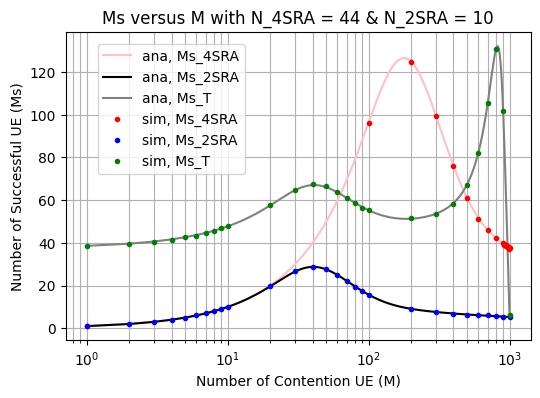

In [27]:
# Ms
plt.plot(ana.M_4SRA, ana.Ms_4SRA, '-', color = 'pink', label = 'ana, Ms_4SRA')
plt.plot(ana.M_2SRA, ana.Ms_2SRA, '-', color = 'black', label = 'ana, Ms_2SRA')
plt.plot(ana.M_2SRA, ana.Ms_T, '-', color = 'gray', label = 'ana, Ms_T')
plt.plot(sim.M_4SRA, sim.Ms_4SRA, 'o', ms = 3, color = 'red', label = 'sim, Ms_4SRA')
plt.plot(sim.M_2SRA, sim.Ms_2SRA, 'o', ms = 3, color = 'blue', label = 'sim, Ms_2SRA')
plt.plot(sim.M_2SRA, sim.Ms_T, 'o', ms = 3, color = 'green', label = 'sim, Ms_T')
plt.xscale('log')
plt.title('Ms versus M with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Number of Successful UE (Ms)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.75))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

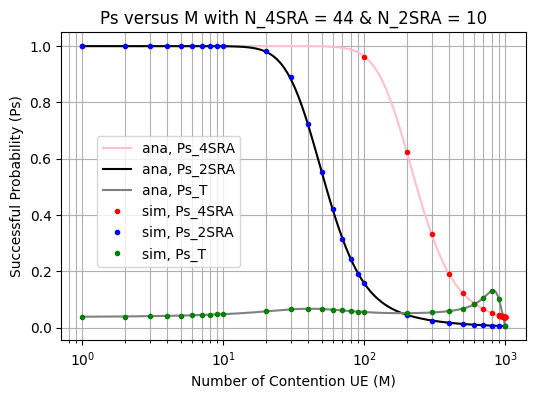

In [37]:
# Ps
plt.plot(ana.M_4SRA, ana.Ps_4SRA, '-', color = 'pink', label = 'ana, Ps_4SRA')
plt.plot(ana.M_2SRA, ana.Ps_2SRA, '-', color = 'black', label = 'ana, Ps_2SRA')
plt.plot(ana.M_2SRA, ana.Ps_T, '-', color = 'gray', label = 'ana, Ps_T')
plt.plot(sim.M_4SRA, sim.Ps_4SRA, 'o', ms = 3, color = 'red', label = 'sim, Ps_4SRA')
plt.plot(sim.M_2SRA, sim.Ps_2SRA, 'o', ms = 3, color = 'blue', label = 'sim, Ps_2SRA')
plt.plot(sim.M_2SRA, sim.Ps_T, 'o', ms = 3, color = 'green', label = 'sim, Ps_T')
plt.xscale('log')
plt.title('Ps versus M with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Successful Probability (Ps)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.45))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

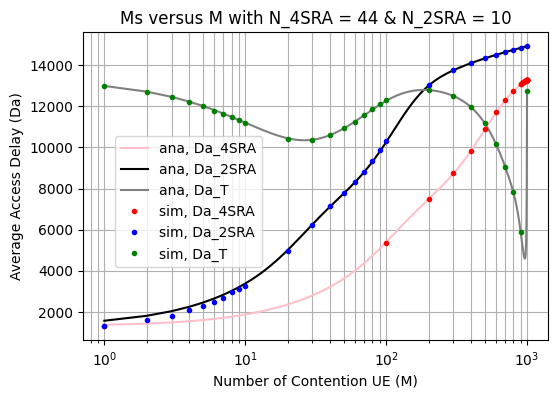

In [39]:
# Da
plt.plot(ana.M_4SRA, ana.Da_4SRA, '-', color = 'pink', label = 'ana, Da_4SRA')
plt.plot(ana.M_2SRA, ana.Da_2SRA, '-', color = 'black', label = 'ana, Da_2SRA')
plt.plot(ana.M_2SRA, ana.Da_T, '-', color = 'gray', label = 'ana, Da_T')
plt.plot(sim.M_4SRA, sim.Da_4SRA, 'o', ms = 3, color = 'red', label = 'sim, Da_4SRA')
plt.plot(sim.M_2SRA, sim.Da_2SRA, 'o', ms = 3, color = 'blue', label = 'sim, Da_2SRA')
plt.plot(sim.M_2SRA, sim.Da_T, 'o', ms = 3, color = 'green', label = 'sim, Da_T')
plt.xscale('log')
plt.title('Ms versus M with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Average Access Delay (Da)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.4, 0.45))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()

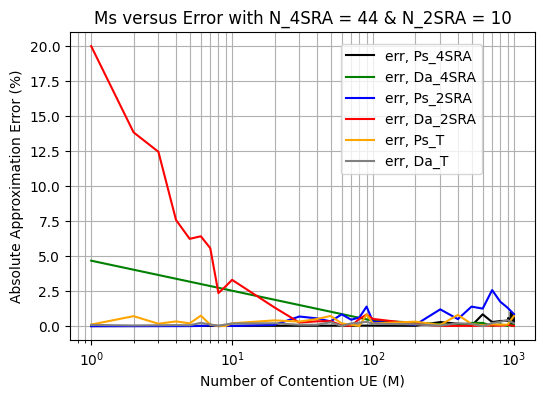

In [47]:
# Error rate
# err_Ms = [0.0 for i in range(0, len(num_UE))]
err_Ps_4SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_4SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Ps_2SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_2SRA = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Ps_T = [0.0 for i in range(0, len(num_UE_2SRA))]
err_Da_T = [0.0 for i in range(0, len(num_UE_2SRA))]
for m in range(0, len(num_UE_2SRA)):
  # err_Ms[m] = float((abs(sim.Ms[m] - ana.Ms[num_UE[m] - 1]) / sim.Ms[m]) * 100)
  err_Ps_4SRA[m] = float((abs(sim.Ps_4SRA[m] - ana.Ps_4SRA[num_UE_2SRA[m] - 1]) / sim.Ps_4SRA[m]) * 100)
  err_Da_4SRA[m] = float((abs(sim.Da_4SRA[m] - ana.Da_4SRA[num_UE_2SRA[m] - 1]) / sim.Da_4SRA[m]) * 100)
  err_Ps_2SRA[m] = float((abs(sim.Ps_2SRA[m] - ana.Ps_2SRA[num_UE_2SRA[m] - 1]) / sim.Ps_2SRA[m]) * 100)
  err_Da_2SRA[m] = float((abs(sim.Da_2SRA[m] - ana.Da_2SRA[num_UE_2SRA[m] - 1]) / sim.Da_2SRA[m]) * 100)
  err_Ps_T[m] = float((abs(sim.Ps_T[m] - ana.Ps_T[num_UE_2SRA[m] - 1]) / sim.Ps_T[m]) * 100)
  err_Da_T[m] = float((abs(sim.Da_T[m] - ana.Da_T[num_UE_2SRA[m] - 1]) / sim.Da_T[m]) * 100)

# plt.plot(sim.M, err_Ms, '-', color = 'green', label = 'err, Ms')
plt.plot(sim.M_4SRA, err_Ps_4SRA, '-', color = 'black', label = 'err, Ps_4SRA')
plt.plot(sim.M_4SRA, err_Da_4SRA, '-', color = 'green', label = 'err, Da_4SRA')
plt.plot(sim.M_2SRA, err_Ps_2SRA, '-', color = 'blue', label = 'err, Ps_2SRA')
plt.plot(sim.M_2SRA, err_Da_2SRA, '-', color = 'red', label = 'err, Da_2SRA')
plt.plot(sim.M_2SRA, err_Ps_T, '-', color = 'orange', label = 'err, Ps_T')
plt.plot(sim.M_2SRA, err_Da_T, '-', color = 'gray', label = 'err, Da_T')
plt.xscale('log')
plt.title('Ms versus Error with N_4SRA = 44 & N_2SRA = 10')
plt.xlabel("Number of Contention UE (M)")
plt.ylabel("Absolute Approximation Error (%)")
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(0.9, 0.75))
plt.rcParams["figure.figsize"] = (6, 4)
plt.show()